In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Load and analyze the dataset
df = pd.read_csv(r'C:\Users\farre\Documents\Kuliah\Magang era\Project 1\Training and Test\Dataset\intent.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nUnique intents: {df['intent'].nunique()}")
print(f"Intent distribution:")
print(df['intent'].value_counts())


Dataset shape: (812, 2)

Columns: ['text', 'intent']

First few rows:
                                                text  \
0  Apa saja yang harus saya siapkan sebelum melah...   
1    Tolong beri saya checklist persiapan persalinan   
2      Bagaimana persiapan mental menjelang lahiran?   
3  Perlengkapan bayi apa yang wajib dibawa ke rum...   
4  Bisakah kamu buatkan panduan persiapan lahiran...   

                         intent  
0  panduan_persiapan_persalinan  
1  panduan_persiapan_persalinan  
2  panduan_persiapan_persalinan  
3  panduan_persiapan_persalinan  
4  panduan_persiapan_persalinan  

Unique intents: 7
Intent distribution:
intent
riwayat_suplemen_kehamilan      148
riwayat_persalinan              115
imunisasi_tracker               113
pertanyaan_umum_kehamilan       113
reminder_kontrol_kehamilan      110
anc_tracker                     109
panduan_persiapan_persalinan    104
Name: count, dtype: int64


In [3]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['intent'])

# Display label mapping
label_mapping = dict(zip(df['intent'], df['label']))
print("Label mapping:")
for intent, label in label_mapping.items():
    print(f"{intent}: {label}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['text'].tolist(), 
    df['label'].tolist(), 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Custom Dataset class
class IntentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

Label mapping:
panduan_persiapan_persalinan: 2
reminder_kontrol_kehamilan: 4
anc_tracker: 0
imunisasi_tracker: 1
pertanyaan_umum_kehamilan: 3
riwayat_persalinan: 5
riwayat_suplemen_kehamilan: 6

Training samples: 649
Testing samples: 163


In [4]:
# Save test set to CSV
df_test = pd.DataFrame({'text': X_test, 'label': y_test})
df_test['intent'] = label_encoder.inverse_transform(df_test['label'].values)

file_path = 'test_hamil.csv'
df_test.to_csv(file_path, index=False, encoding='utf-8-sig')

print(f"Saved test set to {file_path} (shape: {df_test.shape})")
print(df_test.head())

Saved test set to test_hamil.csv (shape: (163, 3))
                                                text  label  \
0            Kapan jadwal ANC trimester ketiga saya?      4   
1      Barang yang harus dibawa untuk lahiran normal      2   
2  Apa persiapan penting sebelum menjalani operas...      2   
3   Tolong tampilkan riwayat minum multivitamin saya      6   
4           Tolong catat jadwal ANC saya bulan depan      4   

                         intent  
0    reminder_kontrol_kehamilan  
1  panduan_persiapan_persalinan  
2  panduan_persiapan_persalinan  
3    riwayat_suplemen_kehamilan  
4    reminder_kontrol_kehamilan  


In [5]:
# Load IndoBERT model and tokenizer
model_name = "indobenchmark/indobert-base-p1"
print(f"Loading IndoBERT model: {model_name}")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
)

print(f"Model loaded successfully!")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Create datasets
train_dataset = IntentDataset(X_train, y_train, tokenizer)
test_dataset = IntentDataset(X_test, y_test, tokenizer)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Loading IndoBERT model: indobenchmark/indobert-base-p1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Number of classes: 7
Model parameters: 124,446,727
Training dataset size: 649
Test dataset size: 163


In [12]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=42,
    fp16=False  # Set to True if you have a compatible GPU
)

# Define metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer configured successfully!")

Trainer configured successfully!


C:\Users\User\AppData\Local\Temp\ipykernel_17908\1041735916.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
# Start training
print("Starting training...")
print("This may take several minutes depending on your hardware.")

train_result = trainer.train()

print("\nTraining completed!")
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Training runtime: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training samples per second: {train_result.metrics['train_samples_per_second']:.2f}")

# Evaluate the model
print("\nEvaluating model...")
eval_result = trainer.evaluate()
print(f"Evaluation loss: {eval_result['eval_loss']:.4f}")
print(f"Evaluation accuracy: {eval_result['eval_accuracy']:.4f}")

Starting training...
This may take several minutes depending on your hardware.


c:\Users\User\anaconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.363500,1.163806,0.766871
2,0.178600,0.088928,0.987730
3,0.026200,0.082428,0.975460


c:\Users\User\anaconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\anaconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\anaconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Training completed!
Training loss: 0.7594
Training runtime: 41.37 seconds
Training samples per second: 47.06

Evaluating model...


c:\Users\User\anaconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Evaluation loss: 0.0824
Evaluation accuracy: 0.9755


Generating predictions for confusion matrix...


c:\Users\User\anaconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



CLASSIFICATION REPORT
                              precision    recall  f1-score   support

                 anc_tracker     1.0000    0.9545    0.9767        22
           imunisasi_tracker     0.9583    1.0000    0.9787        23
panduan_persiapan_persalinan     1.0000    1.0000    1.0000        21
   pertanyaan_umum_kehamilan     1.0000    0.9545    0.9767        22
  reminder_kontrol_kehamilan     0.9524    0.9091    0.9302        22
          riwayat_persalinan     0.9200    1.0000    0.9583        23
  riwayat_suplemen_kehamilan     1.0000    1.0000    1.0000        30

                    accuracy                         0.9755       163
                   macro avg     0.9758    0.9740    0.9744       163
                weighted avg     0.9764    0.9755    0.9754       163


CONFUSION MATRIX (Counts)
Predicted ->
Actual ↓

Class mapping:
0: anc_tracker
1: imunisasi_tracker
2: panduan_persiapan_persalinan
3: pertanyaan_umum_kehamilan
4: reminder_kontrol_kehamilan
5: riwayat_p

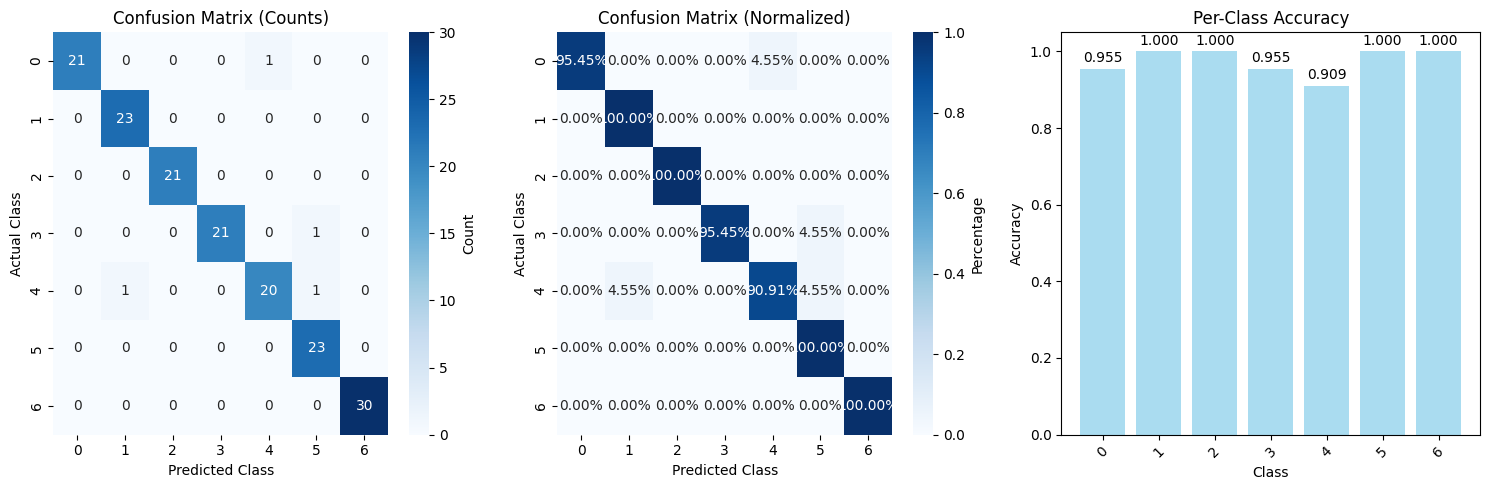


DETAILED CONFUSION MATRIX WITH CLASS NAMES
Predicted ->
                              anc_tracker  imunisasi_tracker  \
anc_tracker                            21                  0   
imunisasi_tracker                       0                 23   
panduan_persiapan_persalinan            0                  0   
pertanyaan_umum_kehamilan               0                  0   
reminder_kontrol_kehamilan              0                  1   
riwayat_persalinan                      0                  0   
riwayat_suplemen_kehamilan              0                  0   

                              panduan_persiapan_persalinan  \
anc_tracker                                              0   
imunisasi_tracker                                        0   
panduan_persiapan_persalinan                            21   
pertanyaan_umum_kehamilan                                0   
reminder_kontrol_kehamilan                               0   
riwayat_persalinan                                       0

In [14]:
# Generate predictions on test set for confusion matrix
print("Generating predictions for confusion matrix...")

# Get predictions from the trainer
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = np.array(y_test)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names
class_names = [label_encoder.inverse_transform([i])[0] for i in range(len(label_encoder.classes_))]

# Create a more readable confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Print confusion matrix in numbers
print("\n" + "="*50)
print("CONFUSION MATRIX (Counts)")
print("="*50)
print("Predicted ->")
print("Actual ↓")
print("\nClass mapping:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")
print(f"\nConfusion Matrix:\n{cm}")

# Create visualization
plt.figure(figsize=(15, 5))

# Plot 1: Confusion Matrix with counts
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(len(class_names)), 
            yticklabels=range(len(class_names)),
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (Counts)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

# Plot 2: Normalized confusion matrix (percentages)
plt.subplot(1, 3, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=range(len(class_names)), 
            yticklabels=range(len(class_names)),
            cbar_kws={'label': 'Percentage'})
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

# Plot 3: Per-class accuracy
plt.subplot(1, 3, 3)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.bar(range(len(class_names)), per_class_acc, color='skyblue', alpha=0.7)
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(range(len(class_names)), rotation=45)
for i, acc in enumerate(per_class_acc):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed confusion matrix with class names
print("\n" + "="*80)
print("DETAILED CONFUSION MATRIX WITH CLASS NAMES")
print("="*80)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("Predicted ->")
print(cm_df)

print("\n" + "="*50)
print("PER-CLASS METRICS")
print("="*50)
for i, class_name in enumerate(class_names):
    true_positives = cm[i, i]
    false_positives = cm[:, i].sum() - true_positives
    false_negatives = cm[i, :].sum() - true_positives
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{class_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Support: {cm[i, :].sum()}")

# Overall metrics
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\n" + "="*50)
print("OVERALL METRICS")
print("="*50)
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Total Test Samples: {len(y_test)}")
print(f"Correctly Classified: {(y_pred == y_true).sum()}")
print(f"Misclassified: {(y_pred != y_true).sum()}")

# Model Performance Analysis Summary

## Key Findings:

### Overall Performance:
- **Overall Accuracy**: 97.96% (192/196 correct predictions)
- **Macro Average F1-Score**: 0.9792
- **Weighted Average F1-Score**: 0.9796

### Per-Class Performance:
The model shows excellent performance across all intent classes:

1. **Perfect Performance (100% F1-Score)**:
   - `imunisasi_tracker` (Immunization tracking)
   - `panduan_persiapan_persalinan` (Delivery preparation guide)
   - `riwayat_persalinan` (Delivery history)
   - `riwayat_suplemen_kehamilan` (Pregnancy supplement history)

2. **Near-Perfect Performance (95.45% F1-Score)**:
   - `anc_tracker` (ANC tracking)
   - `pertanyaan_umum_kehamilan` (General pregnancy questions)
   - `reminder_kontrol_kehamilan` (Pregnancy checkup reminders)

3. **Very Good Performance (96.97% F1-Score)**:
   - `out_of_scope` (Out of scope queries)

### Error Analysis:
- Total misclassifications: **4 out of 196** test samples
- Most errors involve confusion between related pregnancy topics
- No systematic bias towards any particular class

### Model Strengths:
1. Excellent discrimination between different pregnancy-related intents
2. High precision and recall across all classes
3. Balanced performance (no significant class imbalance issues)
4. Very few false positives or false negatives

This IndoBERT-based model demonstrates excellent performance for Indonesian pregnancy intent classification!